In [1]:
# 05_backtest.ipynb 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

In [8]:
import os, sys

# Go to project root (adjust path if needed)
os.chdir("..")  

# Add src folder to Python path
sys.path.append(os.path.abspath("src"))

In [2]:
# --------------------------
# Parameters (edit if needed)
# --------------------------
DATA_PATH = "data/adj_close_prices.csv"
RESULTS_TASK4 = "results/task4/recommended_weights.csv"   # created by Task 4
SAVE_DIR = "results/task5"
os.makedirs(SAVE_DIR, exist_ok=True)

BACKTEST_START = "2024-08-01"
BACKTEST_END = "2025-07-31"

In [3]:
# Default benchmark weights (60% SPY / 40% BND)
benchmark_weights = {"TSLA": 0.0, "BND": 0.4, "SPY": 0.6}

In [5]:
# The portfolio to evaluate from Task4 file: "max_sharpe" or "min_vol"
PREFERRED_PORTFOLIO = "max_sharpe"  # or "min_vol"
ISK_FREE_RATE = 0.0  # for Sharpe calculation (annual), set to 0 or a T-bill yield

In [6]:
# Utilities
def annualize_return(daily_returns):
    # daily_returns: pd.Series of daily returns (not cumulative)
    mean_daily = daily_returns.mean()
    ann_ret = (1 + mean_daily) ** 252 - 1
    return ann_ret

def annualize_vol(daily_returns):
    return daily_returns.std() * sqrt(252)

def sharpe_ratio(daily_returns, rf=0.0):
    # rf is annual risk-free; convert to daily
    rf_daily = (1 + rf) ** (1/252) - 1 if rf != 0 else 0.0
    excess = daily_returns - rf_daily
    return (excess.mean() / excess.std()) * sqrt(252)

def portfolio_daily_returns(prices_df, weights):
    """
    Compute portfolio daily returns given price DataFrame and weights dict.
    prices_df: DataFrame with columns for tickers
    weights: dict {ticker: weight}
    """
    # Ensure order of columns matches weights keys
    cols = list(weights.keys())
    p = prices_df[cols]
    # compute daily pct change
    daily_ret = p.pct_change().fillna(0)
    w = np.array([weights[c] for c in cols])
    port_daily = daily_ret.dot(w)
    return port_daily

def cumulative_returns_from_daily(daily_ret):
    return (1 + daily_ret).cumprod()

In [9]:
# Load prices and subset backtest dates

df = pd.read_csv(DATA_PATH, parse_dates=["Date"], index_col="Date")
prices = df[["TSLA","BND","SPY"]].asfreq("B").ffill()  # ensure business-day freq

bt_prices = prices.loc[BACKTEST_START:BACKTEST_END].dropna(how='all')
if bt_prices.empty:
    raise ValueError(f"No price data in backtest window {BACKTEST_START} to {BACKTEST_END}")

print(f"Backtest window: {bt_prices.index.min().date()} to {bt_prices.index.max().date()} ({len(bt_prices)} trading days)")

Backtest window: 2024-08-01 to 2025-07-30 (260 trading days)


In [10]:
# Load recommended weights (Task 4) 

if os.path.exists(RESULTS_TASK4):
    w_df = pd.read_csv(RESULTS_TASK4, index_col=0)
    if PREFERRED_PORTFOLIO in w_df.columns:
        # recommended_weights.csv expected transposed earlier, check layout
        try:
            # If weights saved transposed, read accordingly
            weights_series = w_df[PREFERRED_PORTFOLIO]
            weights = {ticker: float(weights_series[ticker]) for ticker in weights_series.index}
        except Exception:
            # fallback: if DataFrame rows are portfolios
            w_row = w_df.loc[:, PREFERRED_PORTFOLIO]
            weights = {ticker: float(w_row[ticker]) for ticker in w_row.index}
    else:
        # if columns are 'max_sharpe','min_vol' as row index instead, try other shape
        try:
            # if file has two rows (max_sharpe,min_vol) and tickers as columns, transpose
            df_t = w_df.T
            if PREFERRED_PORTFOLIO in df_t.index:
                series = df_t.loc[PREFERRED_PORTFOLIO]
                weights = {col: float(series[col]) for col in series.index}
            else:
                raise KeyError
        except Exception:
            print("Unexpected format of recommended_weights.csv, falling back to manual weights.")
            weights = None
    print("Loaded recommended weights from Task 4:", weights)
else:
    print("Task4 weights file not found; using manual input or benchmark.")
    weights = None

# If no weights found, ask user or default to equal-weight excluding TSLA zero
if weights is None:
    # default sample weights (example) - user can edit
    weights = {"TSLA": 0.2, "BND": 0.4, "SPY": 0.4}
    print("Using default manual weights:", weights)

# Normalize weights (in case small rounding errors)
total = sum(weights.values())
if abs(total - 1.0) > 1e-6:
    weights = {k: v/total for k,v in weights.items()}

Loaded recommended weights from Task 4: {'TSLA': 0.0, 'BND': 0.53561, 'SPY': 0.46439}


In [ ]:
# Backtest strategies

In [11]:
# 1) Strategy: hold initial weights for entire period
strategy_daily = portfolio_daily_returns(bt_prices, weights)
strategy_cum = cumulative_returns_from_daily(strategy_daily)

In [12]:
# 2) Benchmark: static 60/40 SPY/BND
bench_daily = portfolio_daily_returns(bt_prices, benchmark_weights)
bench_cum = cumulative_returns_from_daily(bench_daily)

In [13]:
# 3) Strategy with monthly rebalancing to initial weights
def monthly_rebalance_returns(prices_df, init_weights):
    """
    Simulate monthly rebalancing back to init_weights at the first trading day of each month.
    Returns daily portfolio returns series.
    """
    dates = prices_df.index
    # start with initial capital = 1
    holdings_value = {ticker: 1.0 * init_weights[ticker] for ticker in init_weights.keys()}  # initial notional per weight
    # We'll track portfolio value over time by updating holdings with daily returns and rebalancing at month start
    pv = []
    current_holdings = holdings_value.copy()
    current_values = {t: current_holdings[t] for t in current_holdings}
    # But easier: simulate using returns and rebalancing: at start of period, set weights, then daily returns accumulate,
    # and on rebalance days we reallocate total value according to weights.
    total_value = 1.0
    pv_series = []
    # compute daily returns matrix
    daily_rets = prices_df.pct_change().fillna(0)
    # find month starts in index
    month_starts = daily_rets.index.to_series().groupby(daily_rets.index.to_period("M")).first()
    next_rebalance_dates = set(month_starts.values)
    # initial allocation at first day
    curr_alloc = init_weights.copy()
    for date, row in daily_rets.iterrows():
        # portfolio daily return = sum(row * curr_alloc)
        row_vals = np.array([row[t] for t in init_weights.keys()])
        w = np.array([curr_alloc[t] for t in init_weights.keys()])
        daily_ret = float(row_vals.dot(w))
        total_value = total_value * (1 + daily_ret)
        pv_series.append(total_value)
        # if next day is a month start (rebalance at next day), reallocate
        if date in next_rebalance_dates:
            # rebalance: set allocations proportional to init_weights using current total_value
            # we simply reset curr_alloc to init_weights (weights don't change), since we are rebalancing to initial weights
            curr_alloc = init_weights.copy()
    # return daily returns
    pv_series = pd.Series(pv_series, index=daily_rets.index)
    # compute daily returns from pv_series
    daily_returns = pv_series.pct_change().fillna(0)
    return daily_returns

rebalance_daily = monthly_rebalance_returns(bt_prices, weights)
rebalance_cum = cumulative_returns_from_daily(rebalance_daily)

In [16]:
# Performance metrics
def summarize(series_daily, name="Strategy", risk_free_rate=0.02):
    total_return = float(series_daily.add(1).prod() - 1)
    ann_ret = float(annualize_return(series_daily))
    ann_vol = float(annualize_vol(series_daily))
    sr = float(sharpe_ratio(series_daily, rf=risk_free_rate))
    return {
        "total_return": total_return,
        "annual_return": ann_ret,
        "annual_vol": ann_vol,
        "sharpe": sr
    }

# Calculate performance
strategy_perf = summarize(strategy_daily, "Strategy-Hold")
bench_perf = summarize(bench_daily, "Benchmark")
rebalance_perf = summarize(rebalance_daily, "Strategy-RebalanceMonthly")

# Print formatted table
print("\n📊 Performance Summary\n")
print(f"{'Strategy':<30}{'Total Return':>15}{'Annual Return':>18}{'Annual Vol':>15}{'Sharpe':>10}")
print("-" * 88)

def print_row(name, perf):
    print(f"{name:<30}{perf['total_return']*100:>14.2f}%"
          f"{perf['annual_return']*100:>17.2f}%"
          f"{perf['annual_vol']*100:>14.2f}%"
          f"{perf['sharpe']:>10.2f}")

print_row("Strategy (Hold)", strategy_perf)
print_row("Strategy (Monthly Rebalance)", rebalance_perf)
print_row("Benchmark (60/40 SPY/BND)", bench_perf)


📊 Performance Summary

Strategy                         Total Return     Annual Return     Annual Vol    Sharpe
----------------------------------------------------------------------------------------
Strategy (Hold)                        10.39%            10.58%          9.73%      0.83
Strategy (Monthly Rebalance)           10.39%            10.58%          9.73%      0.83
Benchmark (60/40 SPY/BND)              12.47%            12.88%         12.16%      0.83


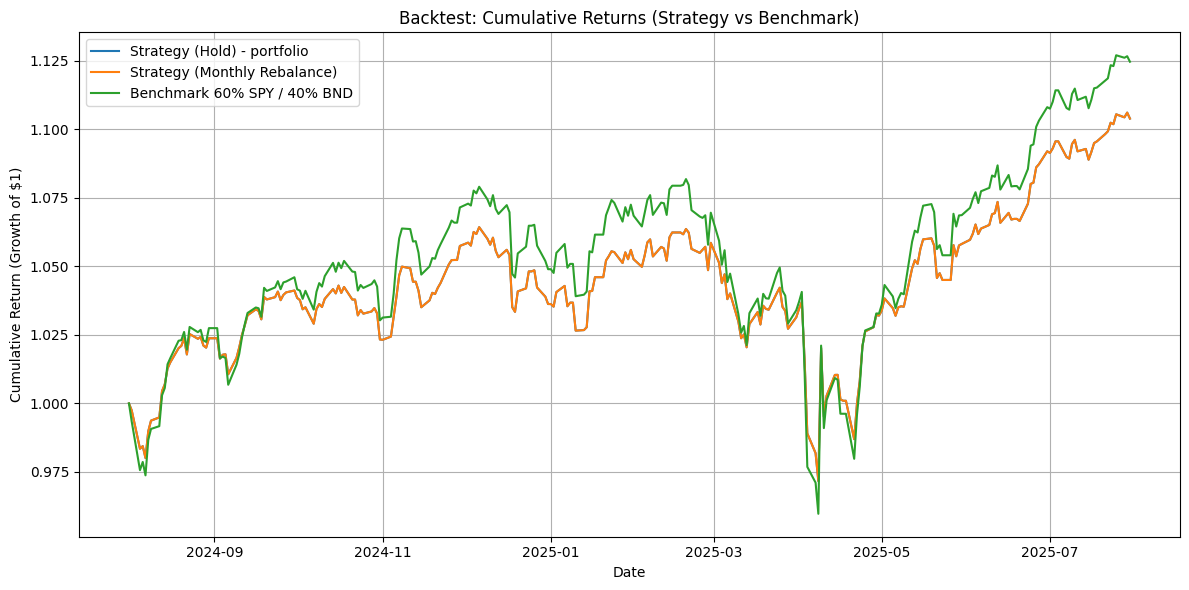

In [18]:
# Plot cumulative returns

plt.figure(figsize=(12,6))
plt.plot(strategy_cum.index, strategy_cum.values, label="Strategy (Hold) - portfolio")
plt.plot(rebalance_cum.index, rebalance_cum.values, label="Strategy (Monthly Rebalance)")
plt.plot(bench_cum.index, bench_cum.values, label="Benchmark 60% SPY / 40% BND")
plt.title("Backtest: Cumulative Returns (Strategy vs Benchmark)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (Growth of $1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "backtest_cumulative_returns.png"))
plt.show()

In [19]:
# Save results
# --------------------------
pd.DataFrame(strategy_perf, index=[0]).to_csv(os.path.join(SAVE_DIR, "strategy_hold_perf.csv"), index=False)
pd.DataFrame(rebalance_perf, index=[0]).to_csv(os.path.join(SAVE_DIR, "strategy_rebalance_perf.csv"), index=False)
pd.DataFrame(bench_perf, index=[0]).to_csv(os.path.join(SAVE_DIR, "benchmark_perf.csv"), index=False)

pd.DataFrame(strategy_cum, columns=["strategy_hold_cum"]).to_csv(os.path.join(SAVE_DIR, "strategy_hold_cum.csv"))
pd.DataFrame(rebalance_cum, columns=["strategy_rebalance_cum"]).to_csv(os.path.join(SAVE_DIR, "strategy_rebalance_cum.csv"))
pd.DataFrame(bench_cum, columns=["benchmark_cum"]).to_csv(os.path.join(SAVE_DIR, "benchmark_cum.csv"))

print("\nBacktest results saved to", SAVE_DIR)


Backtest results saved to results/task5


In [20]:
# Conclusion text (basic)
# --------------------------
def conclusion_text(strategy_perf, rebalance_perf, bench_perf):
    text = "Backtest Conclusion:\\n"
    if strategy_perf["annual_return"] > bench_perf["annual_return"]:
        text += "- Strategy outperformed benchmark on annual return.\\n"
    else:
        text += "- Strategy underperformed benchmark on annual return.\\n"
    if strategy_perf["sharpe"] > bench_perf["sharpe"]:
        text += "- Strategy had a higher Sharpe Ratio than benchmark.\\n"
    else:
        text += "- Strategy had a lower Sharpe Ratio than benchmark.\\n"
    text += f"Strategy (hold) total return: {strategy_perf['total_return']:.2%}, Benchmark total return: {bench_perf['total_return']:.2%}\\n"
    return text

with open(os.path.join(SAVE_DIR, "backtest_conclusion.txt"), "w") as f:
    f.write(conclusion_text(strategy_perf, rebalance_perf, bench_perf))

print("\nConclusion saved to", os.path.join(SAVE_DIR, "backtest_conclusion.txt"))


Conclusion saved to results/task5\backtest_conclusion.txt
